In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

# ========== 参数 ==========
stocks = ["VOO", "VEA", "QQQ", "FNGS", "VWO", "IAU", "BNDX"]
start_date = "2023-05-01"
end_date = "2025-09-30"
risk_free_rate = 0.02   # 无风险利率

In [2]:
# ========== 从 stooq 直接下载 CSV ==========
def get_stooq_data(symbol):
    url = f"https://stooq.com/q/d/l/?s={symbol.lower()}.us&i=d"
    df = pd.read_csv(url)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date").sort_index()
    return df[["Open", "High", "Low", "Close", "Volume"]]

print("正在从 stooq 下载数据...")
raw_data = {}

for s in stocks:
    try:
        df = get_stooq_data(s)
        raw_data[s] = df
        print(f"{s} 下载成功")
    except Exception as e:
        print(f"{s} 下载失败: {e}")
        
# ========== 自动复权处理（后复权） ==========
# 🔹 高亮标记：这是复权处理核心 🔹
def auto_adjust_prices(df):
    df = df.sort_index(ascending=True)
    df['Adj_Factor'] = 1.0
    
    # Stooq 没有分红数据，简单方法：假设股息列叫 'Dividends'，用户可替换
    if 'Dividends' in df.columns:
        divs = df[df['Dividends'] > 0]['Dividends']
        for date, div in divs.items():
            # 历史价格在除息日之前都要调整
            mask = df.index < date
            df.loc[mask, 'Adj_Factor'] *= df.loc[mask, 'Close'] / (df.loc[mask, 'Close'] - div)
    
    # 计算复权价
    df['Adj_Close'] = df['Close'] * df['Adj_Factor']
    df['Adj_Open'] = df['Open'] * df['Adj_Factor']
    df['Adj_High'] = df['High'] * df['Adj_Factor']
    df['Adj_Low'] = df['Low'] * df['Adj_Factor']
    return df

# 对所有股票做复权
for s in raw_data.keys():
    raw_data[s] = auto_adjust_prices(raw_data[s])

# ========== 合并复权收盘价 ==========
data = pd.DataFrame({s: df['Adj_Close'] for s, df in raw_data.items()})
data = data.loc[(data.index >= start_date) & (data.index <= end_date)]
data = data.dropna(axis=1)

print("\n有效股票:", list(data.columns))

正在从 stooq 下载数据...
VOO 下载成功
VEA 下载成功
QQQ 下载成功
FNGS 下载成功
VWO 下载成功
IAU 下载成功
BNDX 下载成功

有效股票: ['VOO', 'VEA', 'QQQ', 'FNGS', 'VWO', 'IAU', 'BNDX']


## 单只表现

In [3]:
# ========== 计算收益与指标 ==========
returns = data.pct_change().dropna()

def performance_metrics(ret_series, name="Stock"):
    cagr = (1 + ret_series).prod() ** (252 / len(ret_series)) - 1
    volatility = ret_series.std() * np.sqrt(252)
    sharpe = (cagr - risk_free_rate) / volatility if volatility > 0 else np.nan
    cum_ret = (1 + ret_series).cumprod()
    drawdown = (cum_ret / cum_ret.cummax() - 1).min()
    return pd.Series({
        "CAGR": cagr,
        "Volatility": volatility,
        "Sharpe": sharpe,
        "Max Drawdown": drawdown
    }, name=name)

metrics = pd.concat([performance_metrics(returns[s], s) for s in data.columns], axis=1).T

print("\n========== 长期回测表现 (2020-2025) ==========")
print(metrics)


========== 长期回测表现 (2020-2025) ==========
          CAGR  Volatility    Sharpe  Max Drawdown
VOO   0.229781    0.151148  1.387924     -0.189703
VEA   0.112993    0.147460  0.630634     -0.143688
QQQ   0.302007    0.200515  1.406417     -0.227684
FNGS  0.496654    0.267956  1.778851     -0.267732
VWO   0.133191    0.157209  0.720005     -0.193979
IAU   0.317144    0.152673  1.946272     -0.112970
BNDX  0.006804    0.046946 -0.281086     -0.051327


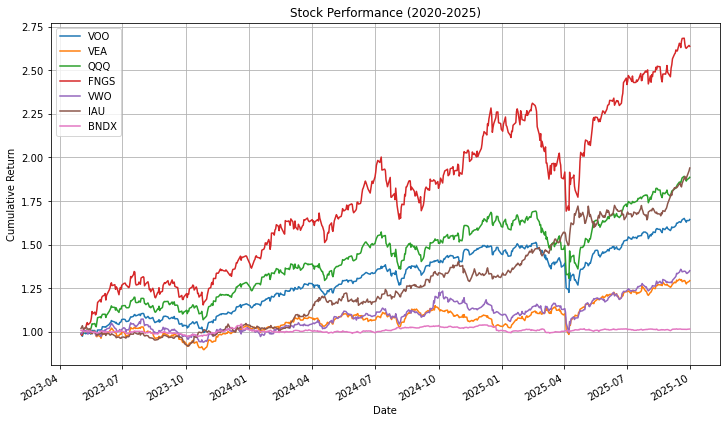

In [4]:
# ========== 绘图 ==========
(1 + returns).cumprod().plot(figsize=(12,7), title="Stock Performance (2020-2025)")
plt.legend(data.columns)
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

## 组合回测

### Monte Carlo法（大数随机法）

In [5]:
print("\nMonte Carlo 计算中...")
# ========== Monte Carlo 投资组合优化 ==========
n_assets = len(data.columns)
n_portfolios = 20000

results = np.zeros((3, n_portfolios))
weights_record = []

for i in range(n_portfolios):
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)
    weights_record.append(weights)
    
    port_ret = np.dot(returns.mean() * 252, weights)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe = (port_ret - risk_free_rate) / port_vol
    
    results[0, i] = port_ret
    results[1, i] = port_vol
    results[2, i] = sharpe

# 找到夏普比率最高的组合
max_sharpe_idx = np.argmax(results[2])
max_sharpe_ret = results[0, max_sharpe_idx]
max_sharpe_vol = results[1, max_sharpe_idx]
max_sharpe_weights = weights_record[max_sharpe_idx]

print("\n========== 最优夏普比率组合 ==========")
for s, w in zip(data.columns, max_sharpe_weights):
    print(f"{s}: {w:.2%}")
print(f"预期年化收益率: {max_sharpe_ret:.2%}")
print(f"预期波动率: {max_sharpe_vol:.2%}")
print(f"夏普比率: {results[2, max_sharpe_idx]:.2f}")


Monte Carlo 计算中...

========== 最优夏普比率组合 ==========
VOO: 7.21%
VEA: 0.12%
QQQ: 11.76%
FNGS: 13.57%
VWO: 4.28%
IAU: 49.21%
BNDX: 13.85%
预期年化收益率: 25.72%
预期波动率: 11.12%
夏普比率: 2.13


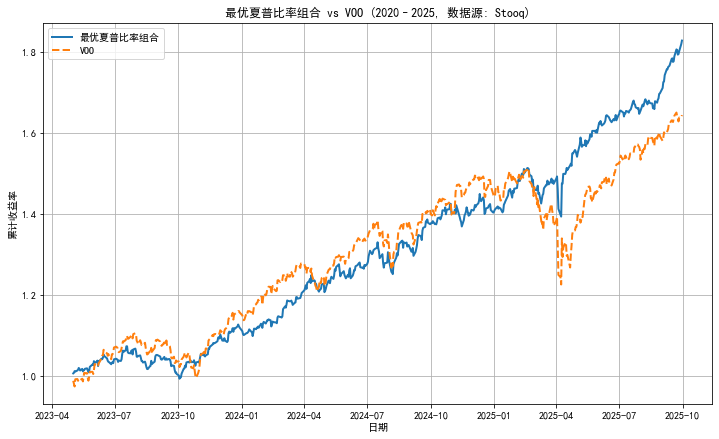

In [6]:
# ========== 计算组合与 VOO 实际表现 ==========
portfolio_daily = (returns * max_sharpe_weights).sum(axis=1)
portfolio_cum = (1 + portfolio_daily).cumprod()
voo_cum = (1 + returns["VOO"]).cumprod()

# ========== 绘图 ==========
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体显示中文
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号
plt.figure(figsize=(12,7))
plt.plot(portfolio_cum, label="最优夏普比率组合", linewidth=2)
plt.plot(voo_cum, label="VOO", linewidth=2, linestyle="--")
plt.title("最优夏普比率组合 vs VOO (2020–2025, 数据源: Stooq)")
plt.xlabel("日期")
plt.ylabel("累计收益率")
plt.legend()
plt.grid(True)
plt.show()

### 均值-方差优化（Mean-Variance Optimization）
通过凸优化求解全局最优，而不是依赖随机采样

========== 最优夏普比率组合 (2020-2025) ==========
VOO: 0.00%
VEA: 0.00%
QQQ: 0.00%
FNGS: 33.41%
VWO: 0.00%
IAU: 66.59%
BNDX: 0.00%

年化收益率: 33.80%
波动率: 13.96%
夏普比率: 2.28


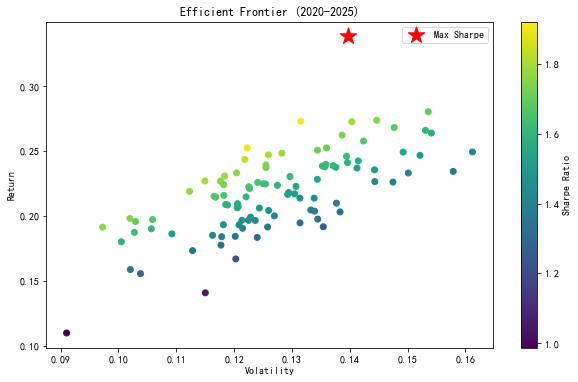

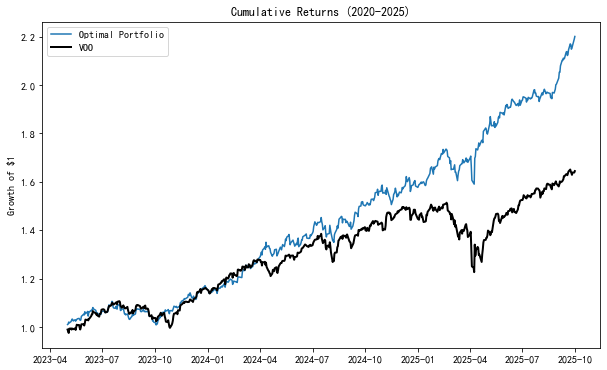

In [7]:
from scipy.optimize import minimize

# ========== 参数 ==========
benchmark = "VOO"

# 年化收益率和协方差矩阵
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

# ========== 投资组合指标函数 ==========
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (ret - risk_free_rate) / vol if vol > 0 else np.nan
    return ret, vol, sharpe

# ========== 优化函数（最大夏普比率） ==========
def neg_sharpe(weights, mean_returns, cov_matrix):
    return -portfolio_performance(weights, mean_returns, cov_matrix)[2]

def max_sharpe_ratio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    constraints = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for _ in range(num_assets))
    result = minimize(neg_sharpe, num_assets*[1./num_assets], 
                      args=(mean_returns, cov_matrix), 
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# ========== 计算最优组合 ==========
opt_result = max_sharpe_ratio(mean_returns, cov_matrix)
opt_weights = opt_result.x
opt_return, opt_vol, opt_sharpe = portfolio_performance(opt_weights, mean_returns, cov_matrix)

print("========== 最优夏普比率组合 (2020-2025) ==========")
for stock, weight in zip(stocks, opt_weights):
    print(f"{stock}: {weight:.2%}")
print(f"\n年化收益率: {opt_return:.2%}")
print(f"波动率: {opt_vol:.2%}")
print(f"夏普比率: {opt_sharpe:.2f}")

# ========== 绘制有效前沿 ==========
def efficient_frontier(mean_returns, cov_matrix, num_points=100):
    results = np.zeros((3,num_points))
    weights_record = []
    num_assets = len(mean_returns)
    
    for i in range(num_points):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        ret, vol, sharpe = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = vol
        results[1,i] = ret
        results[2,i] = sharpe
        weights_record.append(weights)
    
    return results, weights_record

results, weights_record = efficient_frontier(mean_returns, cov_matrix)

plt.figure(figsize=(10,6))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='viridis', marker='o')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(opt_vol, opt_return, marker='*', color='r', s=300, label='Max Sharpe')
plt.title("Efficient Frontier (2020-2025)")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.legend()
plt.show()

# ========== 累计收益曲线 ==========
# 组合收益率 = 各股票日收益率 * 权重
portfolio_returns = returns.dot(opt_weights)
cum_portfolio = (1 + portfolio_returns).cumprod()
cum_benchmark = (1 + returns[benchmark]).cumprod()

plt.figure(figsize=(10,6))
plt.plot(cum_portfolio, label="Optimal Portfolio")
plt.plot(cum_benchmark, label=benchmark, linewidth=2, color="black")
plt.title("Cumulative Returns (2020-2025)")
plt.ylabel("Growth of $1")
plt.legend()
plt.show()